# Introduction to stochastic variational inference in pyro

## Inferring coin bias with the beta-binomial model

In [1]:
import numpy as np
import pyro.distributions as dist
import pyro
from torch.distributions import constraints
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import torch

In [2]:
from tqdm import tqdm

In [3]:
import arviz as az
import matplotlib.pyplot as plt

Specify the joint density 

In [4]:
def model(data):    
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    for i in range(len(data)):
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])  # Don't worry, we will vectorize this later

Specify the variational family

In [5]:
def guide(data):  # guide and model must have the same signature, despite us not actually using the data in this case
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0), # optimization initialization
                         constraint=constraints.positive, # constrained optimization
                        )  # requires_grad is automatically set to True
    beta_q = pyro.param("beta_q", torch.tensor(15.0), 
                        constraint=constraints.positive)
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

Specify optimizer

In [6]:
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

In [7]:
d = torch.tensor(np.random.binomial(n=1, p=0.55, size=10), dtype=float)

In [8]:
n_steps = 1000

for step in tqdm(range(n_steps)):
    svi.step(d)

100%|██████████| 1000/1000 [00:04<00:00, 222.70it/s]


Grab the learned variational parameters

In [9]:
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

In [10]:
def summarize_beta(alpha, beta):
    inferred_mean = alpha / (alpha + beta)
    
    factor = beta / (alpha * (1.0 + alpha + beta))
    inferred_std = inferred_mean * np.sqrt(factor)
    return inferred_mean, inferred_std

In [11]:
summarize_beta(alpha_q, beta_q)

(0.587195867889499, 0.08806620063452536)

## Conditional independence and subsampling

The objective is to not have to touch every data point during inference, but rather approximate the log likelihood with mini-batches. Let $\boldsymbol{x}$ denote a data vector of observations, and $\boldsymbol{z}$ denote a vector of latent random variables 

$$\sum_{i=1}^N \log p(\boldsymbol{x}_i | \boldsymbol{z}) \approx \frac{N}{M} \sum_{i \in \mathcal{I}_M}^N \log p(\boldsymbol{x}_i | \boldsymbol{z})$$

where $\mathcal{I}_M$ is a mini-batch of indices of size $M$. To do this, we require the variational family to be a **conditionally conjugate model**, see [Blei's review](https://arxiv.org/pdf/1601.00670.pdf).

The `pyro.plate` allows us to encode conditional independence in the model. Let's do that:

In [12]:
def model_vec(data):    
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    for i in pyro.plate("data_loop", len(data)):
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])  # this allows us to leverage conditional independence of the observations given the latent variables

Let's make this more efficient by:
- Vectorizing 
- Subsampling, so we can mini-batch

In [13]:
def model_vec_subsampled(data):    
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    with pyro.plate("observe_data", 
                    
                    # Size is required so that the correct scaling factor can be computed
                    size=len(data), 
                    
                    # We only evaluate the log likelihood for 5 randomly chosen datapoints in the data, 
                    # and the log likelihood will automatically get scaled by N/M
                    subsample_size=5,  
                                    
                    # set the device to use a GPU
                    # device = 
                    
                    # A stateful subsampling scheme may be necessary -- it is possible to never touch 
                    # some data points if the dataset is sufficiently large
                    # subsample = 
                   ) as ind:
        pyro.sample("obs", dist.Bernoulli(f), obs=data.index_select(0, ind))  # this will be a tensor of length 5  

In [14]:
svi = SVI(model_vec_subsampled, guide, optimizer, loss=Trace_ELBO())

In [15]:
n_steps = 1000

for step in tqdm(range(n_steps)):
    svi.step(d)

100%|██████████| 1000/1000 [00:01<00:00, 513.25it/s]


In [16]:
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

In [17]:
summarize_beta(alpha_q, beta_q)

(0.5967929619869111, 0.08767387194467353)

## Conditionally conjugate models

We may also have conditional independence in the variational distribution (the `guide`) too.

Let $\beta$ be a vector of global latent variables, which potentially govern any of the data. Let $z$ be a vector of local latent variables, whose $i$th component only governs data in the $i$th "context". The joint density of a conditionally conjugate model is:

$$p(\beta, \boldsymbol{z}, \boldsymbol{x}) = p(\beta) \prod_{i=1}^n p(z_i, x_i | \beta)$$

The variational family (according to the pyro docs, though I don't yet get how this gels with the review) should factorize like

$$p(\beta, \boldsymbol{z}) = p(\beta) \prod_{i=1}^n p(z_i | \beta, \lambda_i)$$

where $\lambda_i$ are local variational parameters (other variational parameters are left implicit). 

To achieve this in `pyro`, a `plate` should be used in both the model and the guide, ensuring that the guide's conditional independence structure respects that of the model.

## MAP estimation

Consider a mixture of Gaussians model

$$\mu_k \sim N(0, \sigma^2), k=1,...,K$$
$$c_i \sim \text{Cat}(1/K, ..., 1/K), i=1,...,n$$
$$x_i|c_i,\mu \sim \mathcal{N}(c_i^T \mu, 1), i=1,...,n$$



We will train a MAP estimator of $\mu_k$ by constructing a Dirac-distribution guide using `AutoDelta`.

See the example in [the docs](https://pyro.ai/examples/gmm.html) also [these notes](https://bookdown.org/robertness/causalml/docs/tutorial-on-deep-probabilitic-modeling-with-pyro.html#gaussian-mixture-model-1).

In [18]:
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

from pyro.infer import config_enumerate
from pyro import poutine
from pyro.contrib.autoguide import AutoDelta
from pyro.infer import TraceEnum_ELBO, config_enumerate

In [19]:
np.random.seed(42)

K = 2
n = 100
sigma_mu = 10.
mu_k = np.random.normal(0, sigma_mu, size=K)
ci = np.random.choice(K, size=n)
sigma = 1
d = []
for i, c in enumerate(ci):
    d.append(np.random.normal(mu_k[c], sigma))
d = np.hstack(d)

In [20]:
mu_k

array([ 4.96714153, -1.38264301])

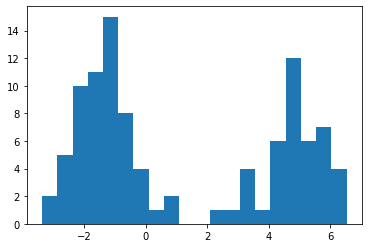

In [21]:
plt.hist(d, bins=int(sigma_mu)*2);

In [22]:
pyro.enable_validation(True)

In [23]:
data = torch.tensor(d, dtype=torch.float)

@config_enumerate
def model_mixture_of_gaussians(data):
    weights = torch.ones(K, dtype=torch.float)/K
    
    with pyro.plate("mu", K):
        locs = pyro.sample("locs", dist.Normal(0., sigma_mu))
        
    with pyro.plate("data", len(data)):
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample('obs', dist.Normal(locs[assignment], 1.), obs=data)

# Let pyro make a guide automatically for us, using Delta distributions to find the parameters of interest (the component locations)
auto_guide = AutoDelta(poutine.block(model_mixture_of_gaussians, expose=['locs']))  # automatically makes a variational distribution from the model for MAP estimation

In [24]:
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

In [25]:
svi = SVI(model_mixture_of_gaussians, auto_guide, optim, loss=elbo)

In [26]:
def initialize(seed, guide):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    
    # Initialize means from a subsample of data.
    pyro.param('auto_locs', data[torch.multinomial(torch.ones(len(data)) / len(data), K)]);
    
    loss = svi.loss(model_mixture_of_gaussians, guide, data)
    return loss

# Choose the best among 100 random initializations.
loss, seed = min((initialize(seed, auto_guide), seed) for seed in range(100))
initialize(seed, auto_guide)
print('seed = {}, initial_loss = {}'.format(seed, loss))

seed = 0, initial_loss = 2702.08056640625


In [27]:
losses = []
for i in tqdm(range(200)):
    loss = svi.step(data)
    losses.append(loss)
    

100%|██████████| 200/200 [00:00<00:00, 308.89it/s]


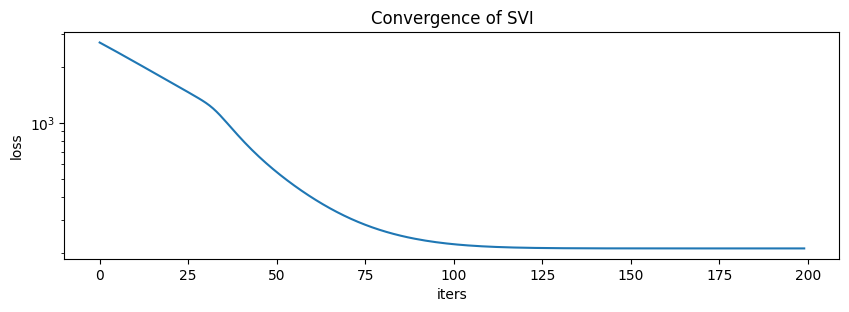

In [28]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI');

In [29]:
map_estimates = auto_guide(data)
locs = map_estimates['locs']
locs

tensor([-1.3439,  4.8388], grad_fn=<ExpandBackward>)

In [30]:
mu_k

array([ 4.96714153, -1.38264301])

Gets pretty close...